* For v2, I removed rare publishers b/c I had too many features(words) due to weird languages
* (25241, 24391). Too many features. Use PCA.
* For specify max & min number of occurence in vectorization step
* Perform clustering on LSA comps, and not NMF.
    * LSA and NMF are dense linear combinations & Clustering makes sense
    * NMF forces coef to be all positive (lose info) & not fit for clustering
    * LSA is unconstrained & can have negative coef & fit for clustering. Faster than NMF
* Do sentiment analysis
    * Add Vader and TextBlob
* CoreEx

To Do
* Compound Terms
* N-grams
* Custom term list in sentiment analysis
* Topic proportion over time


# For Presentation

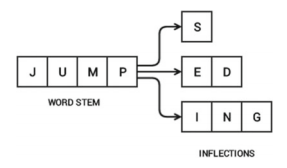

In [233]:
from IPython.display import Image
Image("stem.png")

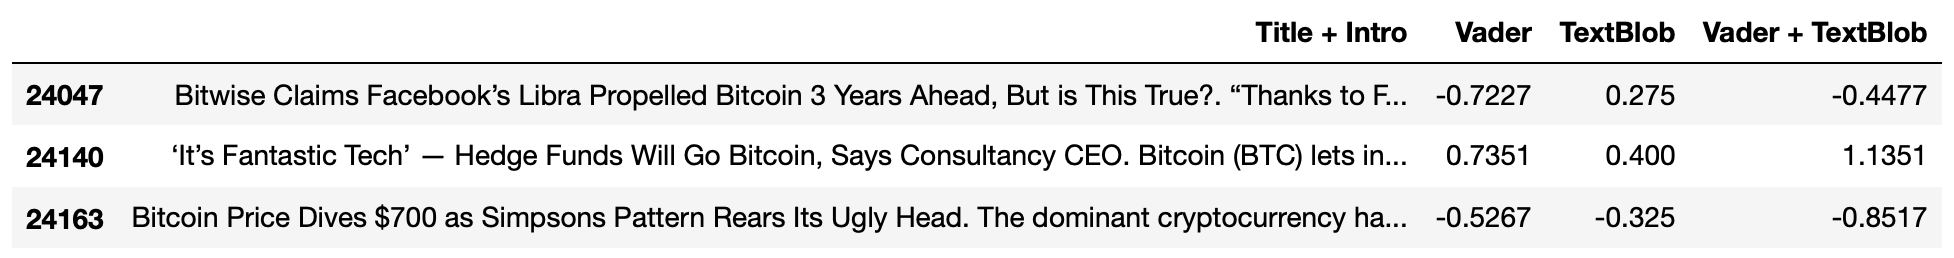

In [234]:
# Magnify positive and negative sentiments while neutralizing somewhat confusing articles
from IPython.display import Image
Image("sentiment.png")
# df_presentation = pd.concat([df_news_clean,df_sentiment,df_sentiment_textblob],axis=1)[['title_intro','compound','txtblob']].iloc[[24047,24140,24163]]
# df_presentation.columns=['Title + Intro','Vader','TextBlob']
# df_presentation['Vader + TextBlob'] = df_presentation['Vader']+df_presentation['TextBlob'] 
# df_presentation


# Resources

Algorithm
* [PCA with Text](https://github.com/silvernine209/nyc19_ds20/blob/master/curriculum/project-04/svd-pca/PCA_with_text_ex.ipynb)  
* [Guided LDA](https://www.freecodecamp.org/news/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164/)

Scraping
* [Scrape Reddit Using API](https://towardsdatascience.com/scraping-reddit-data-1c0af3040768)  
* [Google Search Operators](https://ahrefs.com/blog/google-advanced-search-operators/)

API
* [CryptoCompare](https://www.cryptocompare.com)

MongoDB & AWS
* [Allow Python to connect to MongoDB on AWS](https://github.com/silvernine209/nyc19_ds20/blob/master/curriculum/project-04/mongodb-prep/python_to_aws_mongo_setup.md) 
* [MongoDB Exercises](https://github.com/silvernine209/nyc19_ds20/tree/master/curriculum/project-04/mongodb-lab)

Cryptocurrency
* [Bitcoin Transaction Time](https://themoneymongers.com/bitcoin-transaction-time/) ~ 10 min  
* [Crypto Sentiment Analysis Guide #1](https://hackernoon.com/sentiment-analysis-in-cryptocurrency-9abb40005d15)
* [Bitcoin Graph](https://www.coindesk.com/price/bitcoin)

Additional Support
* [NLP Resources](https://github.com/stepthom/text_mining_resources)  
* [Practitioner's NLP Guide](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72)
* [Metis Project 4 Folder](https://github.com/silvernine209/nyc19_ds20/tree/master/curriculum/project-04)  
* [Udacity Project Customer Segmentation](https://github.com/silvernine209/Udacity-Projects/blob/master/Segment%20Customers/customer_segments.ipynb)

Paper Trading
* [Alpaca](https://app.alpaca.markets/signup)
* [QuantConnect](https://www.quantconnect.com)

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

**max_df** = 0.50 means "ignore terms that appear in more than 50% of the documents".
**max_df** = 25 means "ignore terms that appear in more than 25 documents".
The default **max_df** is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

**min_df** is used for removing terms that appear too infrequently. For example:


**min_df** = 0.01 means "ignore terms that appear in less than 1% of the documents".
**min_df** = 5 means "ignore terms that appear in less than 5 documents".
The default **min_df** is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.


# Import Libraries

In [1]:
# Web Scraping
from bs4 import BeautifulSoup
from lxml import html
import requests


# NLP
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from contractions import CONTRACTION_MAP
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
from nltk.tokenize import MWETokenizer # multi-word expression
from nltk.tag import pos_tag
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')

from gensim import corpora, models, similarities, matutils
import spacy
#python -m spacy download en_core_web_md
import en_core_web_md
import langdetect
nlp = en_core_web_md.load(parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
#nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list+=['crypto','Crypto' 'cryptocurrencie', 'cryptocurrencies', 'Cryptocurrencies', 
                'cryptocurrency','Cryptocurrency', 'btc','Bitcoin','bitcoin','cryptocryptocurrencie']

# stopword_list.remove('no')
# stopword_list.remove('not')
from sklearn.decomposition import NMF
from spacy import displacy
#!pip install vaderSentiment 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Tools
import string
from datetime import date,timedelta,datetime
import unicodedata
import time
import re
import os
import pandas as pd
import numpy as np
import pickle
import random
from tqdm import tqdm, trange
from sklearn import preprocessing

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
#pd.reset_option('^display.', silent=True) #Resets all pandas options

# Functions

#### Helper Functions

In [59]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
# Load all scraped pickle files and combine it to one dataframe
def combine_pickle_files(folder_name): 
    # Location of git folder
    git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))

    # list of pickled files
    pickle_list = os.listdir(git_folder_location+'/'+folder_name+'/')
    if '.DS_Store' in pickle_list:
        pickle_list.remove('.DS_Store')

    # Create a DataFrame to dump all individual DataFrames from scraped data
    with open(folder_name+'/'+pickle_list[0], 'rb') as picklefile: 
        df = pickle.load(picklefile)    
    df_merged = pd.DataFrame(columns=df.keys())

    for file in pickle_list:
        with open(folder_name+'/'+file, 'rb') as picklefile: 
            df = pickle.load(picklefile)
        df_merged = pd.concat([df_merged,df],ignore_index=True,axis=0)
    return df_merged


# example) do not -> don't. I would -> I'd
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# standardized into ASCII characters. example) converting é to e
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text 

# Special characters and symbols
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

# JUMPS, JUMPED, and JUMPING -> JUMP
# Multiple Stemmers : PorterStemmer, LancasterStemmer, SnowballStemmer WordNetLemmatizer
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def normalize_corpus(corpus, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

#### Named Entity Recognition (NER)

In [130]:
# Named Entity Recognition (NER)
sentence = "James Smith lives in the United States."
sentence_nlp = nlp(df_news_clean['title_intro'][4])

# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[($, 'MONEY'), (120, 'MONEY'), (Billion, 'MONEY')]


#### Compound Term Extraction

In [83]:
# Compoun Term Extraction
my_text = "You all are the greatest students of all time."
mwe_tokenizer = MWETokenizer([('You','all'), ('of', 'all', 'time')])
mwe_tokens = mwe_tokenizer.tokenize(word_tokenize(my_text))
mwe_tokens

['You_all', 'are', 'the', 'greatest', 'students', 'of_all_time', '.']

#### Speech Tagging

In [90]:
# Speech Tagging
my_text = "James Smith lives in the United States."
tokens = pos_tag(word_tokenize(my_text))
print(tokens)
nltk.help.upenn_tagset()

[('James', 'NNP'), ('Smith', 'NNP'), ('lives', 'VBZ'), ('in', 'IN'), ('the', 'DT'), ('United', 'NNP'), ('States', 'NNPS'), ('.', '.')]
$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'an

# Scraping

#### Google News Scraping Function

In [ ]:
# Load webpage's url and load it into soup
def load_soup(url):
    user_agent_list = [
       #Chrome
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
        'Mozilla/5.0 (Windows NT 5.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
        'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
         ]
    

    
    headers = {"User-Agent":random.choice(user_agent_list)}
    response = requests.get(url,headers=headers)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    return soup,response.status_code

# Scrape bitcoin news data
def scrape_bitcoin_news_google(start_date,end_date,num_per_page):
    # Create "news_data" folder if it's not there
    git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))
    if 'news_data' not in os.listdir(git_folder_location):
        !mkdir 'news_data'

    # already scraped (list from what's already saved in the folder)
    done_list = os.listdir(git_folder_location+'/news_data/')
    if '.DS_Store' in done_list:
        done_list.remove('.DS_Store')
    
    # Using trange to have a progress bar to gauge scraping time
    for i in trange((end_date-start_date).days):    
        # Month, day, and year to be embedded into the url
        M=start_date.month
        D=start_date.day
        Y=start_date.year 
        
        # File name to save pickle file and not to scrape if already scraped
        filename = 'google_news_{}_{}_{}.pkl'.format(M,D,Y)
        
        # if file isn't scraped, go ahead and scrape
        if filename not in done_list:
            # Load data
            base_url = 'https://www.google.com/search?q=cryptocurrency+or+bitcoin&num=40&rlz=1C5CHFA_enUS849US849&biw=573&bih=717&source=lnt&tbs=cdr%3A1%2Ccd_min%3A{}%2F{}%2F{}%2Ccd_max%3A{}%2F{}%2F{}&tbm=nws&num={}'
            url= base_url.format(M,D,Y,M,D,Y,num_per_page)
            soup,response_code = load_soup(url)
            if response_code !=200:
                print("Blacklisted...?")
                print(start_date)
                break
            
            # Empty lists for DataFrame
            publishers = []
            titles = []
            intros = []
            dates = []  

            # Append data to list
            publishers += [publisher.text for publisher in soup.find_all('div', attrs = {'class': 'pDavDe RGRr8e'})]
            titles += [title.text for title in soup.find_all('div', attrs = {'class': 'phYMDf nDgy9d'})]
            intros += [intro.text for intro in soup.find_all('div', attrs = {'class': 'eYN3rb'})]
            dates += [start_date]*len(publishers)
            
            # Turn data into DataFrame
            df = pd.DataFrame({'date':dates,'publisher':publishers,'title':titles,'intro':intros})
            if len(df)<1:
                print("Empty df")
                break
            # Pickle scraped data
            with open('news_data/'+filename, 'wb') as picklefile:
                pickle.dump(df, picklefile)
            # Move onto next day
            start_date+=timedelta(days=1)
            
#             # Randomly sleep any time between 10 and 12 seconds
#             time.sleep(random.randint(10,12))
        # If file has been scraped, continue
        else:
            # Move onto next day
            print("{} has already been scraped.".format(filename))
            start_date+=timedelta(days=1)




#### Bitcoin Price Scraping Function

In [ ]:
# Scrape bitcoin news data
def scrape_bitcoin_price(start_date,end_date):
    # Create "price_data" folder if it's not there
    git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))
    if 'price_data' not in os.listdir(git_folder_location):
        !mkdir price_data

        
    # File name to save pickle file and not to scrape if already scraped
    filename = 'bitcoin_price_{}_{}.pkl'.format(start_date,end_date)

    # Load data
    start_date = start_date
    end_date = end_date
    url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start={}&end={}'.format(start_date,end_date)
    soup,response_code = load_soup(url)
    # Check if data was loaded successfully
    if response_code !=200:
        print("Blacklisted...?")

    data = []
    # Find all table elements
    table = soup.find_all('tr', attrs = {'class': 'text-right'})
    for row in table:
        data.append(row.text.split('\n')[1:-1])

    # Create dataframe and convert columns to right data types
    df_price = pd.DataFrame(data,columns=['date','open','high','low','close','volume','market_cap'])
    df_price['date'] = df_price['date'].astype('datetime64[ns]') 
    df_price['open'] = df_price['open'].astype(float) 
    df_price['high'] = df_price['high'].astype(float) 
    df_price['low'] = df_price['low'].astype(float) 
    df_price['close'] = df_price['close'].astype(float) 
    df_price['volume'] = df_price['volume'].str.replace(',', '').astype(float)
    df_price['market_cap'] = df_price['market_cap'].str.replace(',', '').astype(float)
    df_price.sort_values(by=['date'],inplace=True)
    df_price.reset_index(drop=True,inplace=True)        
        
    # Pickle scraped data
    with open('price_data/'+filename, 'wb') as picklefile:
        pickle.dump(df_price, picklefile)
        
    return df_price

#### Scrape Google News Data

In [4]:
# # Scrape Data by passing in start_date, end_date, num_articles_per_day
# # Pages before Google blacklists an IP : 73,65,116,97,71,94,80,79,85,88,84,66,79,76,96,92.
# scrape_bitcoin_news_google(date(2019, 6, 8),date(2019, 8, 13),40) #date.today()

# # Combine individual day pickle files & pickle it
# df_news_raw = combine_pickle_files('news_data')
# df_news_raw.sort_values(by=['date'],inplace=True)
# df_news_raw.reset_index(drop=True,inplace=True)
# with open('df_news_raw.pkl','wb') as picklefile:
#     pickle.dump(df_news_raw,picklefile)

#### Clean and Save DataFrame

In [17]:
# Load df_news_raw
with open('df_news_raw.pkl', 'rb') as picklefile: 
    df_news_raw = pickle.load(picklefile) 
    
# Combine title & intro
df_news_raw['title_intro'] = df_news_raw['title']+'. '+df_news_raw['intro']

# Remove '\n' from corpus
df_news_raw['title_intro'] = df_news_raw['title_intro'].apply(lambda x : x.replace('\n',''))

# Detect language
df_news_raw['language'] = df_news_raw['title_intro'].copy()
df_news_raw['language'] = df_news_raw['title_intro'].apply(lambda x : langdetect.detect(x))
df_news_raw = df_news_raw[df_news_raw['language']=='en']
df_news_raw.reset_index(drop=True,inplace=True)

# Apply various NLP processes in 'normalize_corpus function'
df_news_raw['title_intro_clean']=normalize_corpus(df_news_raw['title_intro'],stopword_removal=False)

# Create both Stemmed and Lemmatized texts
#df_news_raw['title_intro_clean_stem'] = df_news_clean['title_intro_clean'].apply(lambda x : simple_stemmer(x))
#df_news_raw['title_intro_clean_lemma'] = df_news_clean['title_intro_clean'].apply(lambda x : lemmatize_text(x))

with open('df_news_clean.pkl','wb') as picklefile:
    pickle.dump(df_news_raw,picklefile)

# Topic Modeling

#### CountVectorizer & NMF

Doc Shape :  (24391, 322)


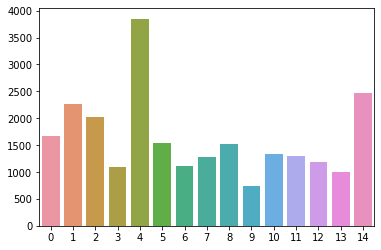

In [474]:
# Load df_news_raw
with open('df_news_clean.pkl', 'rb') as picklefile: 
    df_news_clean = pickle.load(picklefile) 

# Create vectorized matrix with stopword
vectorizer = CountVectorizer(stop_words=stopword_list,max_df=0.10,min_df=0.01)#,max_df=0.30, min_df=0.01)
#vectorizer = CountVectorizer(ngram_range=(1, 2),stop_words=stopword_list,max_df=0.10,min_df=0.005)#,max_df=0.30, min_df=0.01)

doc_word = vectorizer.fit_transform(df_news_clean['title_intro_clean'])

print("Doc Shape : ",doc_word.shape)

# Define NMF model
nmf_model = NMF(n_components=15, init='random', random_state=0)
doc_topics = nmf_model.fit_transform(doc_word)

# Check cluster distribution
doc_cluster = doc_topics.argmax(axis = 1)
sns.barplot(x=pd.Series(doc_cluster).value_counts().keys(),y=pd.Series(doc_cluster).value_counts().values);

In [487]:
# pd.DataFrame(doc_word.toarray(), index=df_news_clean['title_intro_clean'], columns=vectorizer.get_feature_names()).head()

In [476]:
t = nmf_model.components_.argsort(axis=1)[:,-1:-8:-1]
topic_words = [[list(vectorizer.vocabulary_.keys())[e-1] for e in l] for l in t]
#topic_words = [[vectorizer.get_feature_names()[e-1] for e in l] for l in t]
topic_words


[['lose', 'show', 'finance', 'people', 'keep', 'launch', 'volume'],
 ['press', 'still', 'network', 'gold', 'cryptocurrencys', 'share', 'percent'],
 ['claim', 'early', 'run', 'eth', 'facebook', 'bad', 'rally'],
 ['build', 'plan', 'tuesday', 'open', 'wednesday', 'money', 'form'],
 ['ceo', 'loss', 'co', 'miner', 'capital', 'last', 'reason'],
 ['account', 'potential', 'volatility', 'power', 'yet', 'run', 'hack'],
 ['investment', 'come', 'alternative', 'case', 'top', 'accept', 'medium'],
 ['ban', 'trump', 'like', 'ico', 'one', 'steal', 'card'],
 ['give', 'open', 'allow', 'ago', 'investor', 'time', 'top'],
 ['increase', 'million', 'call', 'early', 'old', 'bch', 'accept'],
 ['news', 'week', 'hour', 'crash', 'open', 'platform', 'say'],
 ['try', 'thursday', 'call', 'power', 'sec', 'base', 'hacker'],
 ['popular', 'per', 'form', 'ethereum', 'bch', 'another', 'eth'],
 ['currently', 'allow', 'believe', 'co', 'hour', 'lot', 'bull'],
 ['ripple', 'think', 'pay', 'total', 'power', 'could', 'since']]

#### CountVectorizer & LDA

Doc Shape :  (24391, 415)


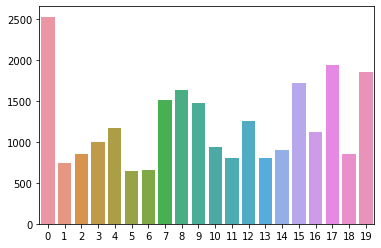

In [507]:
# Create vectorized matrix with stopword
vectorizer = CountVectorizer(stop_words=stopword_list,max_df=0.20,min_df=0.008)
# vectorizer = CountVectorizer(ngram_range=(1, 2),stop_words=stopword_list,max_df=0.20,min_df=0.005)
doc_word = vectorizer.fit_transform(df_news_clean['title_intro_clean'])
print("Doc Shape : ",doc_word.shape)

# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word.transpose())

# We need to save a mapping (dict) of row id to word (token) for later use by gensim:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaMulticore(corpus=corpus, num_topics=20, id2word=id2word, passes=5, workers=1)

# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

# View Topic Distribution
doc_cluster = [sorted(doc,key=lambda row:row[1])[::-1][0][0] for doc in lda_docs]
sns.barplot(x=pd.Series(doc_cluster).value_counts().keys(),y=pd.Series(doc_cluster).value_counts().values);

# # Check out the document vectors in the topic space for the first 5 documents
# lda_docs[:5]

**Libra** - Facebook's currency  
**Binance** - is a global cryptocurrency exchange that provides a platform for trading more than 100 cryptocurrencies. Since early 2018, Binance is considered as the biggest cryptocurrency exchange in the world in terms of trading volume.

In [508]:
lda.print_topics()

[(0,
  '0.150*"price" + 0.060*"high" + 0.036*"hit" + 0.032*"fall" + 0.029*"surge" + 0.029*"month" + 0.027*"time" + 0.025*"week" + 0.025*"rise" + 0.022*"since"'),
 (1,
  '0.163*"million" + 0.067*"steal" + 0.062*"need" + 0.058*"worth" + 0.053*"billion" + 0.050*"lose" + 0.049*"dollar" + 0.039*"hacker" + 0.036*"attack" + 0.028*"part"'),
 (2,
  '0.185*"launch" + 0.070*"plan" + 0.046*"south" + 0.044*"reveal" + 0.040*"korea" + 0.039*"create" + 0.039*"first" + 0.038*"new" + 0.038*"announce" + 0.036*"giant"'),
 (3,
  '0.209*"mining" + 0.073*"purchase" + 0.066*"miner" + 0.050*"card" + 0.050*"mine" + 0.044*"use" + 0.039*"target" + 0.038*"power" + 0.035*"block" + 0.022*"call"'),
 (4,
  '0.149*"digital" + 0.126*"currency" + 0.091*"asset" + 0.062*"ban" + 0.057*"invest" + 0.037*"india" + 0.036*"china" + 0.027*"virtual" + 0.025*"like" + 0.025*"country"'),
 (5,
  '0.236*"trading" + 0.078*"two" + 0.059*"volume" + 0.042*"begin" + 0.036*"platform" + 0.036*"accept" + 0.034*"store" + 0.033*"app" + 0.031*"st

#### Tf-idf & NMF

Doc Shape :  (24391, 322)


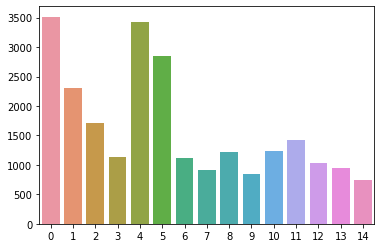

In [479]:
# new TF-IDF Vectorizer
cv_tfidf = TfidfVectorizer(stop_words=stopword_list,max_df=0.1,min_df=0.01)
X_tfidf = cv_tfidf.fit_transform(df_news_clean['title_intro_clean'])


# Define NMF model
nmf_model = NMF(n_components=15, init='random', random_state=0)
doc_topics = nmf_model.fit_transform(X_tfidf)

print("Doc Shape : ",X_tfidf.shape)

# Check cluster distribution
doc_cluster = doc_topics.argmax(axis = 1)
sns.barplot(x=pd.Series(doc_cluster).value_counts().keys(),y=pd.Series(doc_cluster).value_counts().values);

In [480]:
t = nmf_model.components_.argsort(axis=1)[:,-1:-8:-1]
topic_words = [[list(cv_tfidf.vocabulary_.keys())[e-1] for e in l] for l in t]
#topic_words = [[vectorizer.get_feature_names()[e-1] for e in l] for l in t]
topic_words

[['lose', 'account', 'potential', 'show', 'volatility', 'yet', 'people'],
 ['press', 'still', 'network', 'gold', 'percent', 'share', 'cryptocurrencys'],
 ['claim', 'eth', 'facebook', 'run', 'rally', 'tuesday', 'bad'],
 ['build', 'plan', 'tuesday', 'wednesday', 'open', 'four', 'money'],
 ['ban', 'ceo', 'trump', 'last', 'miner', 'steal', 'capital'],
 ['think', 'pay', 'total', 'power', 'run', 'number', 'raise'],
 ['investment', 'alternative', 'come', 'accept', 'medium', 'case', 'use'],
 ['early', 'bch', 'open', 'bad', 'increase', 'rally', 'lead'],
 ['give', 'investor', 'time', 'ago', 'allow', 'open', 'record'],
 ['co', 'launch', 'project', 'loss', 'send', 'top', 'value'],
 ['news', 'week', 'hour', 'crash', 'open', 'platform', 'say'],
 ['try', 'increase', 'thursday', 'call', 'power', 'sec', 'low'],
 ['per', 'ripple', 'form', 'could', 'eth', 'send', 'industry'],
 ['currently', 'allow', 'believe', 'lot', 'gold', 'bull', 'hour'],
 ['popular', 'loss', 'ethereum', 'another', 'need', 'bring', 'w

#### Tf-idf & LDA

(24391, 2339)


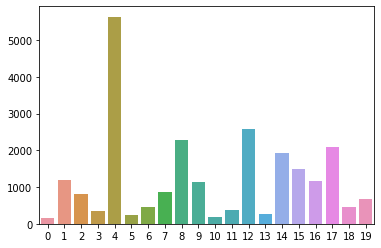

In [423]:
# new TF-IDF Vectorizer
cv_tfidf = TfidfVectorizer(stop_words=stopword_list,max_df=0.15,min_df=0.001,)
# cv_tfidf = TfidfVectorizer(stop_words=stopword_list,max_df=0.6,min_df=0.005,ngram_range=(1, 2))
doc_word = cv_tfidf.fit_transform(df_news_clean['title_intro_clean'])

print(doc_word.shape)

# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word.transpose())

# We need to save a mapping (dict) of row id to word (token) for later use by gensim:
id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())

# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaMulticore(corpus=corpus, num_topics=20, id2word=id2word, passes=5, workers=1)

# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

# View Topic Distribution
doc_cluster = [sorted(doc,key=lambda row:row[1])[::-1][0][0] for doc in lda_docs]
sns.barplot(x=pd.Series(doc_cluster).value_counts().keys(),y=pd.Series(doc_cluster).value_counts().values);

# # Check out the document vectors in the topic space for the first 5 documents
# lda_docs[:5]

In [424]:
# id2word

In [425]:
lda.print_topics()

[(0,
  '0.029*"tax" + 0.021*"guidance" + 0.016*"irs" + 0.014*"initial" + 0.013*"identify" + 0.013*"victim" + 0.013*"allege" + 0.013*"offering" + 0.012*"bias" + 0.012*"pullback"'),
 (1,
  '0.025*"mining" + 0.016*"miner" + 0.012*"mine" + 0.012*"blockstream" + 0.011*"iran" + 0.010*"atms" + 0.009*"privacy" + 0.009*"developer" + 0.009*"xmr" + 0.008*"use"'),
 (2,
  '0.027*"trump" + 0.015*"war" + 0.014*"fan" + 0.014*"wright" + 0.013*"bitmain" + 0.013*"donald" + 0.011*"craig" + 0.011*"president" + 0.010*"bubble" + 0.010*"mark"'),
 (3,
  '0.020*"yuan" + 0.017*"letter" + 0.015*"rich" + 0.012*"drag" + 0.012*"sure" + 0.012*"couple" + 0.012*"feed" + 0.011*"imf" + 0.011*"must" + 0.011*"court"'),
 (4,
  '0.029*"price" + 0.028*"market" + 0.011*"high" + 0.010*"trade" + 0.010*"week" + 0.009*"time" + 0.009*"cap" + 0.008*"top" + 0.008*"see" + 0.008*"gain"'),
 (5,
  '0.033*"coinbase" + 0.028*"wallet" + 0.027*"stablecoin" + 0.022*"exchange" + 0.022*"tether" + 0.021*"bch" + 0.021*"address" + 0.015*"deposit" 

#### CoreEX

In [491]:
#!pip install corextopic
#!pip install networkx
import scipy.sparse as ss

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


2016
- Bitcoin as payment
- Satoshi
- august - hackers attack Bitfinex steal 120 000 bitcoin
- sept - bitcoin atm increase

2017
- April - Japan recognize bitcoin as legal payment
- Dec - South Korea regulate bitcoin trading, potential closure of exchange. Price fall

2018  
- jan - Korea requires Face ID for trading
- jan - FB ban bitcoin advertising
- Feb - price drop a lot
- mar - google&twitter prohibits online ad for crypto
- apr - India’s largest trading platform lost 3 million
- May - Goldman gets involved with bitcoin
- May - justice department investigate manipulators
- June - Korea’s Coinrail loses more that 40 million in tokens after hacking

2019
- mar - Iran, which banned bitcoin before, now accept them 



In [552]:
'''
Use your domain knowledge (use anchors)
Use low anchor strength (2) in order to have as broad a match as possible
____________________________________________________________________________________
Highlight smaller topics that may be otherwise hidden by larger topics (use anchors)
Use high anchor strength (5+) in order to force topics
Likely means that there will be fewer documents matched to the topic
____________________________________________________________________________________
To see how the same word can be used in different topics (use anchors)
Anchor the same word multiple times

'''
# Create vectorized matrix with stopword
vectorizer = CountVectorizer(stop_words=stopword_list,max_df=0.30,min_df=0.001,binary=True)
# vectorizer = CountVectorizer(ngram_range=(1, 2),stop_words=stopword_list,max_df=0.20,min_df=0.005)
doc_word = vectorizer.fit_transform(df_news_clean['title_intro_clean'])
words = list(np.asarray(vectorizer.get_feature_names()))
print("Doc Shape : ",doc_word.shape)

topic_model = ct.Corex(n_hidden=13, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=df_news_clean['title_intro_clean'],
                anchors=[['mining' ]
                         ,['platform']
                         ,['ico']
                         ,['price']
                         ,['market']
                         ,['hack']
                         ,['regulation']
                         ,['payment']
                        ], anchor_strength=3)

topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

Doc Shape :  (24391, 2340)
0: mining,miner,mine,bitmain,operation,electricity,pool,rig,farm,energy
1: platform,trading,bakkt,content,social,bitmex,etoro,crowdfunde,fiat,ice
2: ico,offering,initial,kong,hong,coin,icos,raise,token,bi
3: price,analysis,prediction,chart,recovery,cryptocurrencys,swing,skyrocket,movement,resistance
4: market,cap,capitalization,billion,bear,total,update,large,dominance,altcoin
5: hack,steal,hacker,korea,south,korean,scheme,scam,million,ransomware
6: regulation,central,government,bank,ban,state,regulator,trump,india,law
7: payment,accept,method,bitpay,merchant,processor,pay,paypal,border,retailer
8: street,wall,founder,ceo,hedge,say,co,fund,buffett,warren
9: blockchain,high,fall,value,year,use,last,hit,drop,rally
10: ethereum,ripple,litecoin,cash,xrp,bch,eth,fork,support,eos
11: exchange,know,people,announce,trade,thing,like,lot,make,many
12: report,get,stock,share,investing,cramer,jim,cryptocurrencie,com,earning


In [547]:
# What are the top documents associated with a topic?

# Let's check out topic : Bank
topic_model.get_top_docs(topic=1, n_docs=2)

[('incent blockchain platform launch decentralized exchange back crowdfund ico for over three year now bitscan have be offer the large bitcoin startup service previously know as the first danish cryptocurrency exchange ',
  0.0),
 ('verge blockchain attack be worth a sober second look the notorious percent attack it be the major fault in cryptocurrency protocol in verge this happen every two hour compare to bitcoin which adjust every ',
  0.0)]

In [548]:
# How do I see which topics CorEx has put each document in?
''' 
Use the .labels attribute to find the topic labels associated with each document that you trained on.
Use the .predict() method to predict labels based on a new doc_word
'''

# Note, instead of using .predict(doc_word), you can also call topic_model.labels
predictions = pd.DataFrame(topic_model.predict(doc_word), columns=['topic'+str(i) for i in range(10)])
predictions.head(3)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,False,True,True,True,False,False,False,False,True,True
1,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,True,True


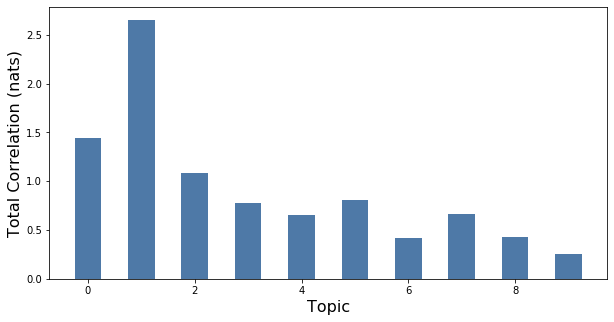

In [549]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

# Sentiment Analysis

In [447]:
# # Load df_news_clean
# with open('df_news_clean.pkl', 'rb') as picklefile: 
#     df_news_clean = pickle.load(picklefile)
    
# # Vader Sentiment Polarity
# analyser = SentimentIntensityAnalyzer()
# scores =[]
# for article in df_news_clean['title_intro']:
#     score = analyser.polarity_scores(article)
#     scores.append(score)
# df_sentiment = pd.DataFrame(scores) # Convert sentiment scores to dataframe

# # TextBlob Sentiment Polarity
# scores =[]
# for article in df_news_clean['title_intro']:
#     score = {'txtblob':np.round(TextBlob(article).sentiment.polarity,4)}
#     scores.append(score)
# df_sentiment_textblob = pd.DataFrame(scores) # Convert sentiment scores to dataframe

# # Concat Vader and TextBlob Sentiment DataFrames
# df_sentiment = pd.concat([df_sentiment,df_sentiment_textblob],axis=1)

# # Concat news dataframe with sentiment dataframe & Create combine two sentiments
# df_news_clean = pd.concat([df_news_clean,df_sentiment],axis=1)
# df_news_clean['final_sentiment'] = (df_news_clean['compound']+df_news_clean['txtblob'])/2

# with open('df_news_sentiment.pkl','wb') as picklefile:
#     pickle.dump(df_news_clean,picklefile)

# Load df_news_clean
with open('df_news_sentiment.pkl', 'rb') as picklefile: 
    df_news_sentiment = pickle.load(picklefile)

In [448]:
# Scrape Bitcoin Price Table
start_date = min(df_news_sentiment['date']).strftime("%Y%m%d")
end_date = max(df_news_sentiment['date']).strftime("%Y%m%d")
df_price = scrape_bitcoin_price(start_date,end_date)

# get daily sentiment score by getting mean of sentiments & concat it with bitcoin price data
df_daily = df_news_sentiment.groupby(['date'], as_index=False).mean().copy()
df_daily = pd.concat([df_daily,df_price[['open', 'high', 'low', 'close', 'volume', 'market_cap']]],axis=1)

# Generate More Features
df_daily['percent_change_daily_open'] = (df_daily['open'].shift(1)-df_daily['open'])/df_daily['open'].shift(1)
df_daily['percent_change_wkly_open'] = df_daily['percent_change_daily_open'].rolling(7).mean()
df_daily['percent_change_monthly_open'] = df_daily['percent_change_daily_open'].rolling(28).mean()
df_daily['percent_change_daily_close'] = (df_daily['close'].shift(1)-df_daily['close'])/df_daily['close'].shift(1)
df_daily['percent_change_wkly_close'] = df_daily['percent_change_daily_close'].rolling(7).mean()
df_daily['daily_sentiment_change'] = (df_daily['final_sentiment'].shift(1)-df_daily['final_sentiment'])#/df_daily['final_sentiment'].shift(1)
df_daily['wkly_sentiment_change'] = df_daily['daily_sentiment_change'].rolling(7).mean()
df_daily['2wk_sentiment_change'] = df_daily['daily_sentiment_change'].rolling(14).mean()
df_daily['3wk_sentiment_change'] = df_daily['daily_sentiment_change'].rolling(21).mean()
df_daily['4wk_sentiment_change'] = df_daily['daily_sentiment_change'].rolling(28).mean()

# Pickle df_daily
with open('df_daily.pkl','wb') as picklefile:
    pickle.dump(df_daily,picklefile)

# Load df_news_clean
with open('df_daily.pkl', 'rb') as picklefile: 
    df_daily = pickle.load(picklefile)
    

Text(0.5, 1.0, 'Sentiment Distribution')

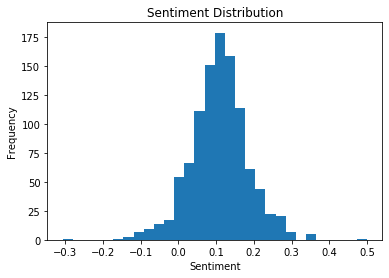

In [336]:
# Compound sentiment distribution
plt.hist(df_daily['final_sentiment'],bins=30)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')

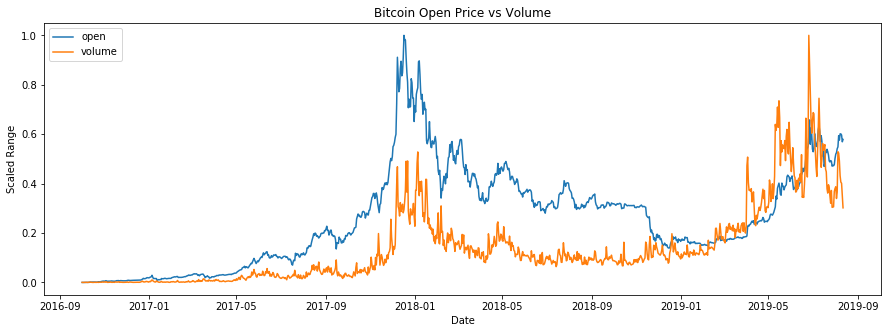

In [305]:
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

plt.figure(figsize=(15,5))
sns.lineplot(x=df_daily['date'],y=min_max_scaler.fit_transform(df_daily['open'].values.reshape(-1,1)).reshape(-1))
sns.lineplot(x=df_daily['date'],y=min_max_scaler.fit_transform(df_daily['volume'].values.reshape(-1,1)).reshape(-1))

plt.xlabel('Date')
plt.ylabel('Scaled Range')
plt.title('Bitcoin Open Price vs Volume')
plt.legend(['open','volume'])

In [441]:
df_daily[df_daily['percent_change_daily_close']>0.15]

,date,neg,neu,pos,compound,txtblob,final_sentiment,open,high,low,...,volume,market_cap,percent_change_daily_open,percent_change_wkly_open,percent_change_daily_close,percent_change_wkly_close,daily_sentiment_change,wkly_sentiment_change,2wk_sentiment_change,3wk_sentiment_change
348,2017-09-14,0.054852,0.854704,0.090407,0.132433,0.123537,0.127985,3875.37,3920.60,3153.86,...,2.716310e+09,5.226545e+10,0.062103,0.023299,0.187411,0.050178,-0.169389,0.000121,0.009686,0.001412
472,2018-01-16,0.033926,0.913444,0.052667,0.086644,0.111259,0.098952,13836.10,13843.10,10194.90,...,1.885380e+10,1.931211e+11,-0.004997,0.011498,0.168548,0.030686,-0.039469,0.001773,0.004890,0.005700
492,2018-02-05,0.091385,0.863500,0.045154,-0.208369,-0.053300,-0.130835,8270.54,8364.84,6756.68,...,9.285290e+09,1.171844e+11,0.098648,0.047457,0.159688,0.064630,0.248450,0.022197,0.005857,0.009063


In [463]:
df_daily.head()

,date,neg,neu,pos,compound,txtblob,final_sentiment,open,high,low,...,percent_change_daily_open,percent_change_wkly_open,percent_change_monthly_open,percent_change_daily_close,percent_change_wkly_close,daily_sentiment_change,wkly_sentiment_change,2wk_sentiment_change,3wk_sentiment_change,4wk_sentiment_change
0,2016-10-01,0.027400,0.846800,0.125800,0.429560,0.161920,0.295740,609.93,615.24,609.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-10-02,0.042222,0.876778,0.080889,0.207922,0.114656,0.161289,613.95,614.01,609.68,...,-0.006591,NaN,NaN,0.005033,NaN,0.134451,NaN,NaN,NaN,NaN
2,2016-10-03,0.042238,0.866190,0.091524,0.204338,0.083195,0.143767,610.97,612.57,610.46,...,0.004854,NaN,NaN,-0.002030,NaN,0.017522,NaN,NaN,NaN,NaN
3,2016-10-04,0.037640,0.868320,0.094040,0.203012,0.055336,0.129174,612.05,612.05,609.48,...,-0.001768,NaN,NaN,0.003153,NaN,0.014593,NaN,NaN,NaN,NaN
4,2016-10-05,0.049531,0.841969,0.108500,0.240938,0.115869,0.178403,610.22,613.81,609.62,...,0.002990,NaN,NaN,-0.003786,NaN,-0.049229,NaN,NaN,NaN,NaN


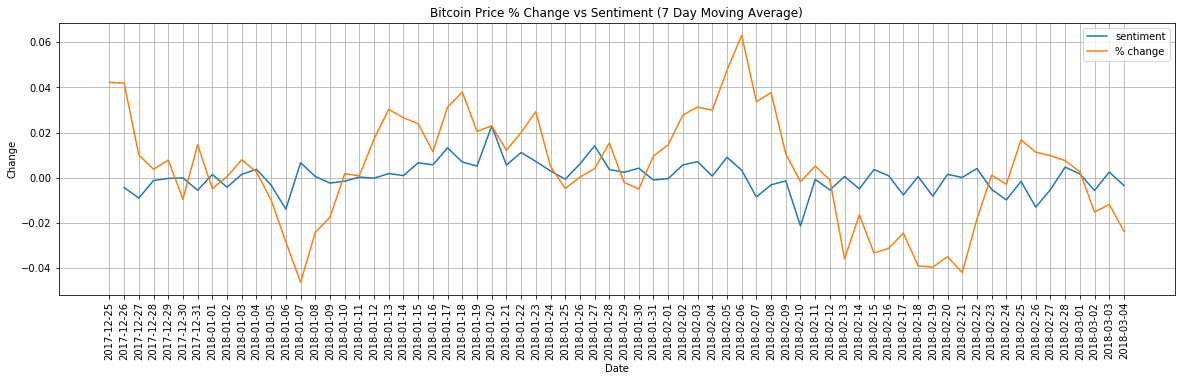

In [442]:
start_index = 450
end_index = 520

plt.figure(figsize=(20,5))
#sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['wkly_sentiment_change'][start_index:end_index])
#sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['2wk_sentiment_change'][start_index:end_index])
sns.lineplot(x=df_daily['date'][start_index+1:end_index+1],y=df_daily['3wk_sentiment_change'][start_index:end_index])
sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['percent_change_wkly_open'][start_index:end_index])

plt.xlabel('Date')
plt.ylabel('Change')
plt.title('Bitcoin Price % Change vs Sentiment (7 Day Moving Average)')
plt.legend(['sentiment','% change'])
plt.xticks(df_daily['date'][start_index:end_index],rotation='vertical')
plt.grid()

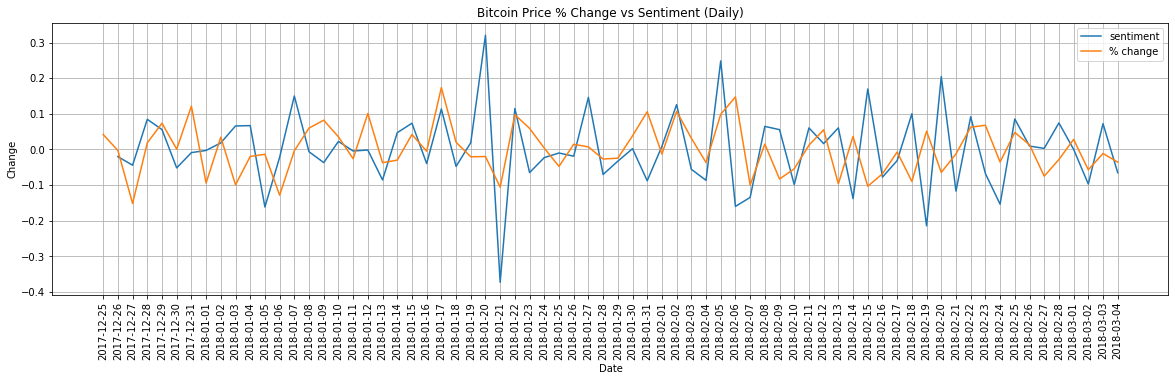

In [464]:
start_index = 450
end_index = 520

plt.figure(figsize=(20,5))
sns.lineplot(x=df_daily['date'][start_index+1:end_index+1],y=df_daily['daily_sentiment_change'][start_index:end_index])
#sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['2wk_sentiment_change'][start_index:end_index])
#sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['3wk_sentiment_change'][start_index:end_index])
#sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['4wk_sentiment_change'][start_index:end_index])
sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['percent_change_daily_open'][start_index:end_index])
#sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['percent_change_monthly_open'][start_index:end_index])


plt.xlabel('Date')
plt.ylabel('Change')
plt.title('Bitcoin Price % Change vs Sentiment (Daily)')
plt.legend(['sentiment','% change'])
plt.xticks(df_daily['date'][start_index:end_index],rotation='vertical')
plt.grid()

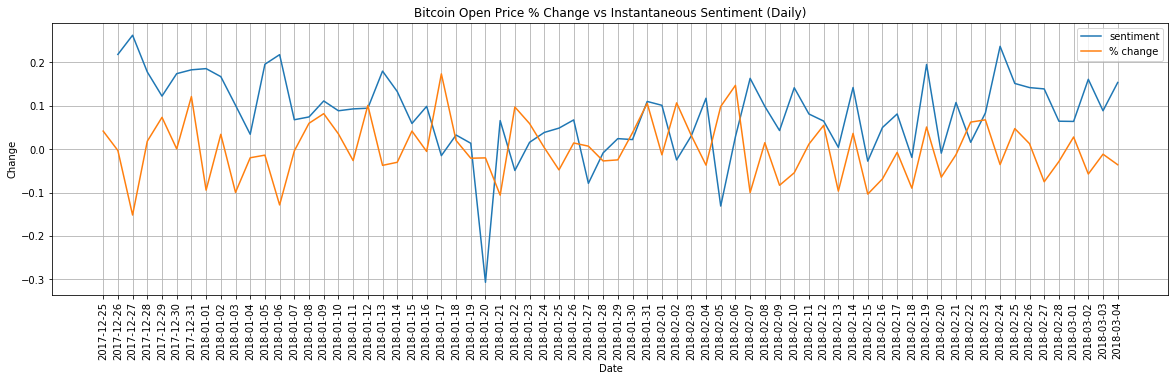

In [445]:
start_index = 450
end_index = 520

# plt.figure(figsize=(20,5))
# sns.lineplot(x=df_daily['date'][start_index+1:end_index+1],y=df_daily['final_sentiment'][start_index:end_index])
# #sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['2wk_sentiment_change'][start_index:end_index])
# #sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['3wk_sentiment_change'][start_index:end_index])
# sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['percent_change_daily_close'][start_index:end_index])

# plt.xlabel('Date')
# plt.ylabel('Change')
# plt.title('Bitcoin Close Price % Change vs Instantaneous Sentiment (Daily)')
# plt.legend(['sentiment','% change'])
# plt.xticks(df_daily['date'][start_index:end_index],rotation='vertical')
# plt.grid()
# plt.show()


plt.figure(figsize=(20,5))
sns.lineplot(x=df_daily['date'][start_index+1:end_index+1],y=df_daily['final_sentiment'][start_index:end_index])
#sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['2wk_sentiment_change'][start_index:end_index])
#sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['3wk_sentiment_change'][start_index:end_index])
sns.lineplot(x=df_daily['date'][start_index:end_index],y=df_daily['percent_change_daily_open'][start_index:end_index])

plt.xlabel('Date')
plt.ylabel('Change')
plt.title('Bitcoin Open Price % Change vs Instantaneous Sentiment (Daily)')
plt.legend(['sentiment','% change'])
plt.xticks(df_daily['date'][start_index:end_index],rotation='vertical')
plt.grid()
plt.show()

# Bitcoin Price Prediction/Recommendation

Use simple NN instead of LSTM. My assumption is that bitcoin prices are affected more instantaneous news/sentiment/price than longer term analysis.

#### Heatmap Preprocessing

In [ ]:
# Heat map with market_train_df
C_mat = market_train_df.corr()
fig = plt.figure(figsize=(15,15))
sb.heatmap(C_mat,vmax=0.5,square=True,annot=True)
plt.show()

#### View Correlation After Outlier Removal

In [ ]:
def remove_outlier(df,column_list,lower_percentile,upper_percentile):
    for i in range(len(column_list)):
        #upper_bound = np.percentile(df[column_list[i]],upper_percentile)
        #lower_bound = np.percentile(df[column_list[i]],lower_percentile)
        df = (df[(df[column_list[i]]<np.percentile(df[column_list[i]],upper_percentile)) & (df[column_list[i]]>np.percentile(df[column_list[i]],lower_percentile))])
    return df
#outlier_removal_list = ['returnsClosePrevRaw1','returnsOpenPrevRaw1','returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevRaw10','returnsOpenPrevRaw10','returnsClosePrevMktres10','returnsOpenPrevMktres10','returnsOpenNextMktres10']
outlier_removal_list = [ 'returnsClosePrevRaw1',
                         'returnsOpenPrevRaw1',
                         'returnsClosePrevRaw10',
                         'returnsOpenPrevRaw10',
                         'returnsOpenNextMktres10']

market_data_no_outlier = remove_outlier(market_train_df,outlier_removal_list,2,98)
print("Number of data decreased from ",len(market_train_df['returnsOpenNextMktres10'])," to ",len(market_data_no_outlier['returnsOpenNextMktres10']))

C_mat = market_data_no_outlier.corr()
fig = plt.figure(figsize=(15,15))
sb.heatmap(C_mat,vmax=0.5,square=True,annot=True)
plt.show()

#### Standardize Data

In [ ]:
from sklearn.preprocessing import StandardScaler
def scale_data(df,features):
    scaler = StandardScaler()
    df[features]=scaler.fit_transform(df[features])
    return df
features = ['returnsClosePrevRaw1',
         'returnsOpenPrevRaw1',
         'returnsClosePrevMktres1',
         'returnsOpenPrevMktres1',
         'returnsClosePrevRaw10',
         'returnsOpenPrevRaw10',
         'returnsClosePrevMktres10',
         'returnsOpenPrevMktres10']    
market_data_no_outlier_scaled = scale_data(market_data_no_outlier,features)

#### Split Data

In [ ]:
# Splits data for training. Takes out 30 days worth of data between training and validation set to prevent data leakage
def split_train_test(x,y,test_size):    
    # Splits data as specified test_size and creates a gap of 30 days between train and test. This helps data leakage so that the model doesn't know the future when training
    X_train = x[x['time']<(x['time'][int(len(x)*(1-test_size))]-timedelta(days=30))]
    y_train = y[y['time']<(y['time'][int(len(x)*(1-test_size))]-timedelta(days=30))]
    X_test = x[x['time']>x['time'][int(len(x)*(1-test_size))]]
    y_test = y[y['time']>y['time'][int(len(y)*(1-test_size))]]   
    # Final Features to be used
    #features = ['returnsClosePrevRaw1','returnsOpenPrevRaw1','returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevRaw10','returnsOpenPrevRaw10','returnsClosePrevMktres10','returnsOpenPrevMktres10'] 
    features = ['returnsClosePrevRaw10','returnsOpenPrevRaw10','returnsClosePrevMktres10']
    
    X_train1 = X_train[features].copy()
    y_train1 = y_train['returnsOpenNextMktres10'].copy()
    train_time = y_train['time']
    
    X_test1 = X_test[features].copy()
    y_test1 = y_test['returnsOpenNextMktres10'].copy()
    test_time = y_test['time']
    return X_train1,X_test1,y_train1,y_test1,train_time,test_time

X_train,X_test,y_train,y_test,train_time,test_time = split_train_test(market_data_no_outlier_scaled,market_data_no_outlier_target,0.1)
print("Test data percentage : {} %".format(len(X_test)/(len(X_train)+len(X_test))*100))

#### Define NN

In [555]:
# Model
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Input
from keras.optimizers import Adam

# Initialize Model
model = Sequential()
# Input layer & hidden layer
model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32,activation='relu'))
# Output layer
model.add(Dense(1))
# Compile the architecture and view summary
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

Using TensorFlow backend.


NameError: name 'X_train' is not defined

#### Early Stopping Callback

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_acc', verbose = 1, save_best_only = True, mode ='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto',restore_best_weights=True)
callbacks_list = [early_stopping]
#callbacks_list = [checkpoint,early_stopping]

#### Train the Model

In [ ]:
model.fit(x=X_train.values,y=y_train.values, epochs=20,shuffle=True,validation_data=(X_test.values, y_test.values),callbacks=callbacks_list)# validation_split=0.2)#) #, callbacks=callbacks_list)

#### Sanity Check

In [ ]:
data = {'y_real':y_test[:20],'y_pred':(model.predict(X_test.values[:20])).reshape(1,-1)[0]}
pd.DataFrame(data)

#### Simple ConfidenceValue Creation Function from Prediction Values

In [ ]:
def make_my_prediction(x):
    my_pred = (model.predict(x)).reshape(1,-1)[0]
    my_pred[my_pred>0]=1
    my_pred[my_pred<0]=-1
    return my_pred

#### Sigma Score

In [ ]:
# sigma_score function is considered as a custom evaluation metric for xgboost
# example of how custom evaluation function is incorporated into xgboost's training can be found here : https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py
def sigma_score(preds,dval,df):
    
    # get y_target values
    labels = dval
    # call time parameter to be used for grouping, so that we can add x_t values for each day
    df_time = df
    
    #calculate x_t and score as specified by the competition
    x_t = pd.Series(preds*labels)
    x_t_sum = x_t.groupby(df_time).sum()    
    score = (x_t_sum.mean())/(x_t_sum.std())
    return 'sigma_score', round(score,5)

my_pred_test = make_my_prediction(X_test.values)
print("test : ",sigma_score(my_pred_test,y_test,test_time))

my_pred_train = make_my_prediction(X_train.values)
print("train : ",sigma_score(my_pred_train,y_train,train_time))